<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [263]:
%%capture
pip install pyswarms

In [264]:
%%capture
pip install scipy

In [265]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [266]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [267]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [268]:
print(locale.getlocale())

('pt_BR', 'ISO8859-1')


In [269]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [270]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [271]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 17000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 1460 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 17000 # Valor para o custo da manutenção corretiva
CMP = 4000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = ('pso')

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_terceiro_cenario'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '03'

In [272]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [273]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [274]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [275]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [276]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [277]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [278]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [279]:
# Função custo de manutenção baseada severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {1.0: 400.0000}
    custos = [dist.get(si, CMP) for si in s]
    custo_total = np.sum(custos)
    return custo_total

In [280]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {1.0: 400.0000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.20 or si > 1.0 else np.interp(si, [1.0], [400.0000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [281]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,0.7,182
1,1309,1,7,0,0.7,366
2,1778,1,7,0,0.7,547
3,0,1,0,0,0.7,731
4,0,0,0,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [282]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [283]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return (-1)*fitness

In [284]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-12-21 23:25:21,870 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0837
2023-12-21 23:25:22,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08369716132174138, best pos: [148.41225848   1.00025993   0.15233147]


In [285]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.4122584844515
beta: 1.0002599275394077
theta: 0.15233147028446048

Tempo de Convergência para a primeira etapa: 0.0072824954986572266 segundos


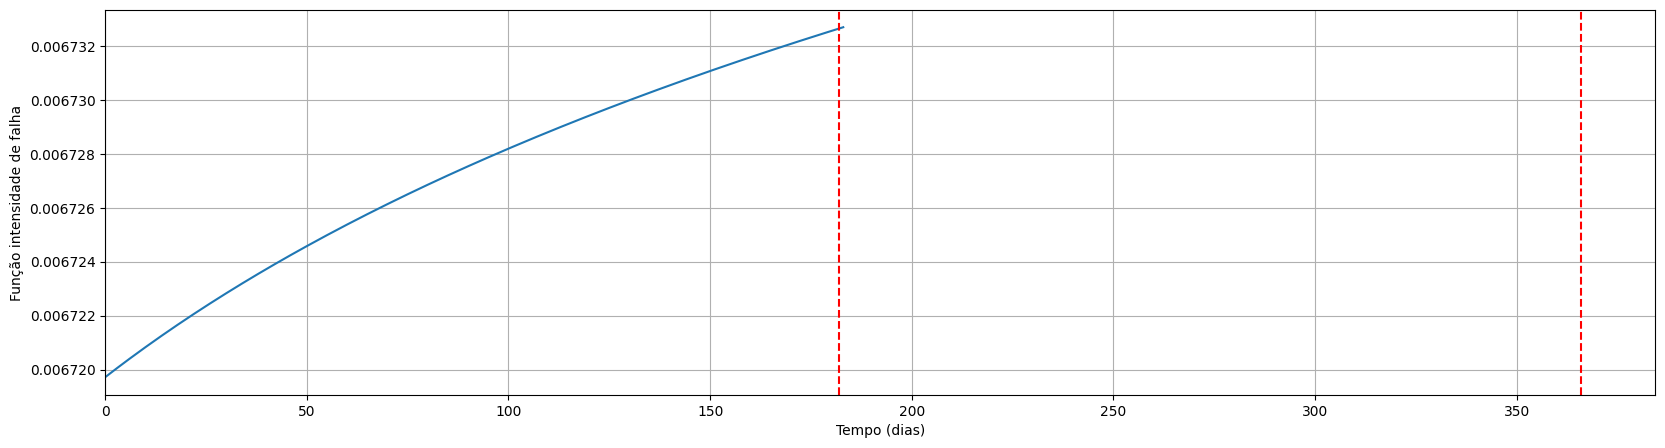

Fator ajuste:  [0.329627346089734, 0.329627346089734, 0.329627346089734, 0.329627346089734, 0.43521856256562297, 0.329627346089734, 0.329627346089734]


In [286]:
lamb = 149.0660105892337
beta = 1.0021041775754342
theta = 0.5713164590755301

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [287]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [288]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:1.0, 3:1.0, 5:1.0, 7:1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo

    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [289]:
num_particles = 100
max_iterations = 100
dimensions = VALOR_DIMENSOES
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([1.3] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-12-21 23:25:23,407 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=348



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 156, 333, 368, 427, 668, 878, 933, 990, 1232, 1267, 1351, 1387]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0466163590453064, 2.237062502871031, 2.4725104443408537, 2.869527279086141, 4.492621642440782, 5.907826080385609, 6.278544538024243, 6.662791754639056, 8.294835742153662, 8.53090140847971, 9.09753029953481, 9.34038704116985, 9.832896578223131]
Custo =  1564.0685157178684


Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 93, 274, 398, 511, 543, 570, 603, 752, 782, 908, 964, 994, 1117, 1172]
Severidade par

pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=348

 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.2147232057195656, 2.836356076231545, 4.055132481423681, 5.46335596986351, 6.05645393000024, 6.676638818108717, 7.512742736647701, 8.11969797124426, 8.537869785791328, 9.833206123292609]
Custo =  1178.3868914435661


Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 182, 241, 337, 367, 428, 488, 603, 727, 813, 990, 1086]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.2214485441819

pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=348



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 487, 693, 870, 902, 1111, 1320]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 3.275157547878523, 4.6630619531145605, 5.855870433815484, 6.071547199374489, 7.480737400611134, 8.890453449036531, 9.83497995224811]
Custo =  826.1949029999003


Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 244, 336, 425, 575, 695, 782, 1087, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.63855685483235, 2.25746465866730

pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=348<ipython-input-288-d3a1771d0f23>:79: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 152, 307, 428, 481, 693, 1205, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0197243055154457, 2.062053936602939, 2.8762347664879235, 3.23296954367601, 4.6609009348711075, 8.113302124600565, 8.89574693527235, 9.833527012297507]
Custo =  940.7363410999582


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 156, 247, 337, 693, 906, 1082, 1111, 1320, 1350, 1382]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=348



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 150, 241, 333, 694, 722, 908, 1206, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0062788347498806, 1.6179835025103988, 2.236704940073018, 4.6679529952669245, 4.856581632872757, 6.1101535055631695, 8.119731422607046, 8.895431191688978, 9.833211268714136]
Custo =  1066.8917659937597


Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 7, 335, 693, 1321, 1386]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.046657823194500875, 2.

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=348



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 6, 694, 904, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.039979450027109224, 4.6706097018431025, 6.085904865138311, 8.898421854420667, 9.836201931445824]
Custo =  644.6075122511671


Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 694, 721, 818, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.67074752173599, 4.852702572635112, 5.506322709949956, 8.89877273418206, 9.836552811207218]
Custo =  596.0651153857459


Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 2, 330, 694, 1202, 1321, 1387]
Severidade para cada subsist

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=348
2023-12-21 23:25:24,889 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989072 0.60825871 0.40405205 0.39680044 0.38514906 1.24762045
 0.68801273 0.5172663  0.10506937 0.69812804 0.62493217 0.83390539
 1.13962597 0.6724794  0.79138155 0.42042105 0.76732004 0.54997762
 0.25308736 0.83584737 0.7776013  0.92231776 1.05510761 1.27064733
 1.15513175 0.67713176 0.9690985  0.04375114 0.89834878 0.90706542
 0.11756255 0.01096581 0.46029832 0.55581824 0.77095279 0.6679715
 0.94260519 0.07389475 0.39610943 0.53285507 1.11431291 1.16569516
 0.86398827 0.42511177 1.05353649 1.13714752 1.17297557 0.86567674]
2023-12-21 23:25:24,893 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 241, 362, 695, 728, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.61836853505566, 2.4324582862176554, 4.675198301086798, 4.897514108175414, 8.896815053545822, 9.83459513057098]
Custo =  708.7394164307303


Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 695, 728, 811, 1207, 1230, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.677491877205994, 4.8998849286645, 5.459160820384997, 8.129517870122788, 8.284637415329108, 8.89845522256014, 9.836235299585297]
Custo =  845.3727

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:24,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16021243 0.6079129  0.40402569 0.39783898 0.38999697 0.28479897
 0.78206916 0.51743785 1.27647377 0.69882263 0.62639991 0.83498166
 1.13971824 0.66958663 0.79822436 0.42012963 0.76731236 0.5498504
 0.61144192 1.15365685 0.77756931 0.92228559 1.05731847 1.25033875
 1.15502225 0.7693861  0.18191149 1.2619458  0.89768968 0.90663681
 0.92698689 0.75278424 0.45956225 0.54588569 0.76936397 0.66883205
 0.93901335 0.07408628 0.39623096 0.53209768 0.59571905 1.16568654
 0.8640901  0.425188   1.05346064 0.78529904 1.17329733 0.86822649]
2023-12-21 23:25:24,917 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 660, 692, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.441451799946073, 4.657082545892576, 8.899105612183982, 9.83688568920914]
Custo =  474.91635295817866


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:24,943 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15936809 0.60780375 0.40402293 0.39743508 0.38288582 1.09561604
 0.757581   0.51706999 0.69143935 0.69899079 0.62646041 0.83009284
 1.1395297  0.66963265 0.80620091 0.42018243 0.76732008 0.54980714
 0.60240868 0.51524953 0.77753167 0.92211251 1.0568181  0.21298919
 1.15501473 0.80130525 0.0413498  0.62300007 0.89737345 0.90554892
 0.30717942 0.91080033 0.46202557 0.54216806 0.76953516 0.66888579
 0.94228693 0.07426376 0.39612038 0.53255073 0.72626077 1.16569632
 0.86414066 0.42504223 1.05339716 0.45690652 1.17329564 0.86763234]
2023-12-21 23:25:24,945 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 661, 690, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 4.643610076500739, 8.899117373199147, 9.836897450224305]
Custo =  476.2063547490211


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:24,962 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15863349 0.60782715 0.40402125 0.39702653 0.37664009 0.42872133
 0.71782093 0.51676428 0.14710259 0.6989774  0.62650958 0.82629041
 1.13937734 0.67018204 0.81025328 0.42023981 0.76732703 0.54979945
 0.64062657 1.17252845 0.77751803 0.92197609 1.05608111 0.2636034
 1.15501076 0.79659907 1.21247856 0.11122254 0.89731694 0.90483489
 1.13911169 1.10960356 0.46379777 0.54056439 0.77006209 0.66888883
 0.94523495 0.07436463 0.39601938 0.53299798 0.71736744 1.16570498
 0.86414817 0.42491317 1.05337026 0.12348559 1.17322453 0.86659876]
2023-12-21 23:25:24,968 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 334, 662, 690, 721, 780, 1208, 1321, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.2444248795778177, 4.453717741498933, 4.642328296972337, 4.8511663032196095, 5.24869438793554, 8.134806902430176, 8.89701657853491, 9.295025808938169, 9.834761583718635]
Custo =  1083.641118837466


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,002 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15825866 0.60787761 0.40401986 0.39659331 0.37188927 0.95534574
 0.67643372 0.51660121 1.08234614 0.69892508 0.62653451 0.82407994
 1.13929998 0.67068227 0.81072509 0.42032807 0.76733248 0.5498429
 0.79816833 0.38904635 0.77751708 0.9219186  1.05536243 0.27649063
 1.15503981 0.76711433 0.96624258 1.07730058 0.89741604 0.90476685
 0.70001454 0.11177413 0.46434431 0.54167465 0.77075299 0.66875479
 0.94757538 0.0743964  0.39595367 0.53336811 0.63268336 1.16571257
 0.86415442 0.42481287 1.0533854  1.14929474 1.17312001 0.86561588]
2023-12-21 23:25:25,003 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 3, 663, 691, 781, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.019960591155694637, 4.461604895858398, 4.650216029026211, 5.25660927203204, 8.89854989798671, 9.836329975011868]
Custo =  842.2050594277018


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,056 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15832942 0.60801341 0.40402717 0.39623399 0.3681667  0.07242083
 0.6417619  0.51659649 0.63410633 0.69879563 0.62611743 0.82269522
 1.13931886 0.67144892 0.80584941 0.42042962 0.767337   0.54990695
 1.06075904 0.9774736  0.77753976 0.92197092 1.0546669  0.27150746
 1.15507994 0.71674418 0.61490328 0.89145533 0.89752381 0.90479432
 0.30844424 0.64030998 0.46470161 0.54277566 0.77142213 0.66850313
 0.94847888 0.07437426 0.39592864 0.53368869 0.47483059 1.16571727
 0.86414908 0.4247339  1.05343644 0.77014963 1.17302049 0.86474185]
2023-12-21 23:25:25,058 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 306, 332, 664, 692, 727, 782, 877, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.0558907023543114, 2.2308169444184096, 4.466578277879288, 4.6551899879032295, 4.890978620017908, 5.261558204763293, 5.90179748854286, 8.896391574072155, 9.834171651097313]
Custo =  1089.4480023198003


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,085 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15848719 0.60819613 0.40404115 0.39599221 0.36654032 0.42615759
 0.61957316 0.51674579 0.33031823 0.69865184 0.62565238 0.82264237
 1.13937779 0.67235641 0.79757276 0.42052089 0.76734022 0.54996465
 1.18540592 0.20346573 0.77757695 0.92209686 1.05412526 0.29141982
 1.15511721 0.6654635  0.23470607 0.6987691  0.89762911 0.90502088
 0.06706703 0.02319713 0.46476723 0.5448977  0.77189634 0.66819732
 0.94782345 0.07430319 0.3959355  0.53382731 0.26539663 1.16571935
 0.8641351  0.42473213 1.0535091  0.34158301 1.17292705 0.86415747]
2023-12-21 23:25:25,089 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 8, 367, 664, 694, 782, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.05333821104058538, 2.466519225950926, 4.466646606074718, 4.668731659746286, 5.261651590861777, 8.896849359578717, 9.834629436603874]
Custo =  874.4643824203707


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 308, 663, 695, 782, 1080, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.0693562631231774, 4.460427163899928, 4.675985045237196, 5.262167481250284, 7.271255003869899, 8.89680174635969, 9.834581823384848]
Custo =  827.1491421641036


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,112 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15868322 0.60836681 0.40405497 0.3958991  0.36524914 0.72202445
 0.61003851 0.5169002  0.16000358 0.69838556 0.62519879 0.8233634
 1.13949092 0.67318357 0.78861876 0.42057841 0.76734023 0.55001787
 0.00619486 0.78936197 0.77761755 0.92222697 1.05390095 0.16388945
 1.15515427 0.6205563  1.25883634 0.56598196 0.89783461 0.90574875
 1.28057536 0.89622052 0.46412722 0.54840878 0.77226768 0.66789211
 0.94653773 0.07422799 0.39597047 0.5339375  0.09402024 1.16571838
 0.86411397 0.4247916  1.05357892 1.22788928 1.17285711 0.86375331]
2023-12-21 23:25:25,115 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 0, 246, 333, 663, 697, 781, 873, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.0, 1.6520160252511424, 2.2371149621659665, 4.459403992128664, 4.688435457151399, 5.254403824763855, 5.87441961878681, 8.895987705759396, 9.833767782784554]
Custo =  inf



2023-12-21 23:25:25,138 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15868322 0.60836681 0.40405497 0.3958991  0.36524914 0.72202445
 0.61003851 0.5169002  0.16000358 0.69838556 0.62519879 0.8233634
 1.13949092 0.67318357 0.78861876 0.42057841 0.76734023 0.55001787
 0.00619486 0.78936197 0.77761755 0.92222697 1.05390095 0.16388945
 1.15515427 0.6205563  1.25883634 0.56598196 0.89783461 0.90574875
 1.28057536 0.89622052 0.46412722 0.54840878 0.77226768 0.66789211
 0.94653773 0.07422799 0.39597047 0.5339375  0.09402024 1.16571838
 0.86411397 0.4247916  1.05357892 1.22788928 1.17285711 0.86375331]
2023-12-21 23:25:25,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,180 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15949037 0.60854603 



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 662, 698, 780, 1113, 1321, 1358, 1384]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.45493910776045, 4.697527377528857, 5.250019227426005, 7.495193043966962, 8.898166691463492, 9.147758273499106, 9.323154329818225, 9.835903698994166]
Custo =  968.0123629654229


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,228 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.1598857  0.60854182 0.40408229 0.39646529 0.38511016 0.7626667
 0.63838964 0.51740885 0.46104215 0.69775114 0.62407024 0.83378686
 1.13973486 0.67476035 0.77735134 0.42049191 0.76732321 0.55006176
 0.97897359 0.41821484 0.7776609  0.92250934 1.05498673 0.79979766
 1.15520055 0.55715561 0.0390551  0.53184512 0.89847172 0.90779791
 0.69404628 0.49735849 0.45931587 0.5580427  0.7721266  0.66762895
 0.94020646 0.07390807 0.3961686  0.5334233  1.01130292 1.16571264
 0.86395459 0.42512357 1.05365085 1.12059586 1.17281246 0.86461602]
2023-12-21 23:25:25,230 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 332, 360, 661, 907, 936, 1114, 1233, 1321, 1351]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.2309570152048055, 2.419371278363767, 4.446407579094238, 6.104310235838411, 6.299782751863226, 7.499972995516032, 8.302534950659478, 8.896117385302803, 9.098486998494504, 9.83387290826685]
Custo =  1204.982635706206


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,266 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16024202 0.60852969 0.40408633 0.39677397 0.39274297 0.59264025
 0.66488286 0.51751395 0.76967912 0.69773089 0.6239185  0.8370879
 1.13974702 0.67492053 0.77834095 0.42042383 0.76731671 0.55003305
 0.12535142 1.21388864 0.77765858 0.92255335 1.05548187 0.23805936
 1.15519567 0.57576494 1.08312566 0.73474242 0.89861561 0.90827308
 0.38294136 0.46062087 0.45809888 0.56001394 0.77173812 0.66774494
 0.93869544 0.07379392 0.39622292 0.53304818 0.70789978 1.16570593
 0.86390904 0.42523889 1.05363953 0.58773666 1.17283735 0.86539058]
2023-12-21 23:25:25,268 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 660, 1113, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.441451799946073, 7.496276812565066, 8.899250460061596, 9.837030537086754]
Custo =  464.6897438770858


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 8, 660, 1113, 1321, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.05333821104058538, 4.441280599094747, 7.495365807033318, 8.898339454529848, 9.296348684933108, 9.836084459713573]
Custo =  751.6055387768539


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16048675 0.6085103  0.40408514 0.39705272 0.39960426 0.48079393
 0.69240022 0.51754856 1.03132291 0.69782855 0.62392282 0.83942551
 1.13972351 0.67457447 0.78096599 0.42036189 0.76731108 0.5499947
 0.66880401 0.54813504 0.77765438 0.92258445 1.05587409 0.88194497
 1.15519089 0.59768297 0.70231774 0.86799973 0.89872694 0.90846529
 0.17985382 0.43329732 0.45757504 0.56174252 0.77132742 0.6679155
 0.93757078 0.073694   0.39626503 0.53269277 0.41074759 1.16569783
 0.8638823  0.42531387 1.05361779 0.07666448 1.17289093 0.86613529]
2023-12-21 23:25:25,296 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 158, 241, 308, 331, 366, 660, 874, 1112, 1206, 1234, 1321, 1357]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0600629322833988, 1.6180059417669292, 2.068533173616047, 2.2232227625958982, 2.4586679677093555, 4.438568957240581, 5.880712566284075, 7.485424082156002, 8.119354502420432, 8.30819678704507, 8.895034091337811, 9.137879623257334, 9.832786386654796]
Custo =  1573.5374459040097


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16062782 0.60848259 0.40407782 0.39728631 0.40207748 0.39944069
 0.71669215 0.51752661 1.25855089 0.69792622 0.62396974 0.84137689
 1.1396775  0.67393257 0.78429713 0.42032021 0.76730808 0.54995753
 1.1679268  1.17584651 0.77764416 0.92260234 1.05600985 0.06807938
 1.15517429 0.62649051 0.25134588 1.01428041 0.89880292 0.90854944
 0.11536566 0.43395925 0.4577445  0.5615435  0.77090079 0.66807065
 0.93769465 0.07363006 0.39625905 0.53240411 0.18414647 1.16569042
 0.86388658 0.42532876 1.05359488 0.7963435  1.17295823 0.86679844]
2023-12-21 23:25:25,325 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,347 - pyswarms.single.global_best - INFO - Optimization finished |



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 660, 811, 931, 1321, 1388]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.441451799946073, 5.4592134981384355, 6.268033284000778, 8.898468830808362, 9.3504502435415, 9.8362131646]
Custo =  706.7419084819659


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 660, 723, 1081, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.441451799946073, 4.86600405800105, 7.279551270718898, 8.898353440592402, 9.83613351761756]
Custo =  585.5471664871516



2023-12-21 23:25:25,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.1607098  0.60831035 0.40405425 0.39744903 0.40216699 0.46646686
 0.7377951  0.51735838 0.61504355 0.69813263 0.62444431 0.83949349
 1.13959148 0.67205024 0.79381459 0.42029795 0.76730557 0.54991711
 0.67683999 0.9927141  0.77760669 0.9224894  1.05579835 1.11286761
 1.15512972 0.69730569 0.71032861 1.06069679 0.89875443 0.90826787
 0.3776319  0.54799328 0.45885897 0.55821981 0.77020007 0.66824931
 0.94055982 0.07366638 0.39618454 0.53219448 0.13406161 1.1656795
 0.86392572 0.42532058 1.05353637 0.96911321 1.17307433 0.867296  ]
2023-12-21 23:25:25,379 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,397 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16047263 0.60822716 



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 155, 240, 660, 874, 904, 933, 1085, 1233, 1321, 1354]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.039893208165897, 1.611271297370153, 4.43932779108124, 5.881471400124733, 6.083669431232435, 6.279140621794817, 7.3039720208068895, 8.302109107698008, 8.895691542341334, 9.118299032906839, 9.833445382235956]
Custo =  1322.8440515878403


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,421 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16020302 0.60815665 0.40403098 0.39706603 0.39707658 0.64851423
 0.72968816 0.51718828 1.2959265  0.69830274 0.624914   0.83349976
 1.13953945 0.67087652 0.8007551  0.42035988 0.767311   0.54991458
 0.37496387 0.62885621 0.77757144 0.92230392 1.05525885 0.48400905
 1.15509159 0.74665042 0.96820391 1.14893322 0.89838829 0.9071217
 0.87119747 0.80745413 0.46043976 0.5538585  0.76988688 0.66815232
 0.94352096 0.07382272 0.39606587 0.53240691 0.51292864 1.16567927
 0.86400284 0.42523879 1.05348688 1.14607856 1.17309111 0.86613656]
2023-12-21 23:25:25,424 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 7, 661, 1087, 1205, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.046657823194500875, 4.448041255229721, 7.319974962729762, 8.115753898679735, 8.898198709351519, 9.835978786376677]
Custo =  754.7451195793863


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 158, 661, 690, 725, 818, 1086, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0600629322833988, 4.447031783673417, 4.642378355246741, 4.8781656121416415, 5.504833295892411, 7.311706421849277, 8.896785665050885, 9.834565742076043]
Custo =  955.0133359815901



2023-12-21 23:25:25,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15994108 0.60810423 0.40402615 0.39682511 0.39055018 0.77720353
 0.71937531 0.51713869 0.35297682 0.69833687 0.62515186 0.83079105
 1.13954355 0.6705961  0.80078875 0.42041475 0.76731517 0.54992304
 0.94282151 1.04052686 0.77756457 0.92221661 1.05494547 0.83915468
 1.15508138 0.75830037 0.40022291 1.09593264 0.8981924  0.90655997
 1.0328396  0.8971102  0.4611115  0.55222278 0.76992505 0.66805143
 0.94460646 0.07392947 0.3960175  0.53259824 0.67354423 1.1656863
 0.8640335  0.42516258 1.05346805 0.48179519 1.1730592  0.86542631]
2023-12-21 23:25:25,464 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15994108 0.60810423 



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 0, 244, 365, 661, 870, 905, 1085, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.0, 1.63855685483235, 2.4524471804007244, 4.4458205369953845, 5.85425819427663, 6.090156106401741, 7.303761738317727, 8.895585575304322, 9.83336565232948]
Custo =  inf


2023-12-21 23:25:25,496 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15957306 0.60810062 0.40402835 0.39650377 0.38053567 0.64760984
 0.68753191 0.51712447 0.85233574 0.69832754 0.62547536 0.82803934
 1.13956149 0.67052185 0.79615553 0.42050906 0.76732321 0.54994935
 1.03643526 0.89122722 0.77757336 0.9221645  1.05460081 1.1032193
 1.15508986 0.72951953 0.35931909 0.91455382 0.89795577 0.90612109
 1.05356628 0.84175033 0.46161742 0.55114671 0.77059558 0.66789261
 0.94508031 0.07408799 0.3959607  0.53289548 0.75492461 1.16569835
 0.8640707  0.42503121 1.05345988 0.53422075 1.17298598 0.86449708]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 157, 661, 723, 780, 811, 876, 930, 1083, 1200, 1321, 1388]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0533396006099431, 4.447034308684958, 4.864707766523801, 5.248760603984672, 5.4576505707866465, 5.8957123982088735, 6.259688142522344, 7.291257449651926, 8.080285693529513, 8.896455662869071, 9.34843707560221, 9.83419999666071]
Custo =  1438.746772220125


2023-12-21 23:25:25,519 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15952785 0.60813133 0.40403092 0.39644597 0.3778833  0.41818696
 0.67407956 0.51716222 0.97825884 0.6982908  0.62548112 0.82834567
 1.13957247 0.67092782 0.79323065 0.42052781 0.76732646 0.54997415
 0.56085374 0.30925337 0.77758389 0.92218279 1.05455318 1.0447988
 1.1551023  0.70781903 0.87463832 0.73757955 0.89793336 0.90611813
 0.87642033 0.86386623 0.46143995 0.55234584 0.77097046 0.66786069
 0.94461478 0.07411698 0.3959541  0.53299279 0.73359372 1.1657015
 0.86406329 0.42500537 1.05346613 1.2696476  1.17294742 0.86436691]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 662, 780, 1081, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.45493910776045, 5.2502284569610715, 7.2795434787607185, 8.898345648634223, 9.83612572565938]
Custo =  582.8148294699118


2023-12-21 23:25:25,543 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,564 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15951063 0.60819672 0.40403581 0.39645138 0.37593623 0.22376157
 0.66363834 0.51720271 1.13403005 0.69821558 0.62542365 0.83020755
 1.13958773 0.67174059 0.79049115 0.42054462 0.76732903 0.54999744
 0.04340027 1.11257944 0.7775974  0.92222453 1.05459605 0.91197383
 1.15511753 0.68224948 0.04151865 0.59075687 0.89798841 0.90632713
 0.62973501 0.84815994 0.46097069 0.55362295 0.7713056  0.66784554
 0.94411309 0.074098   0.39599406 0.53304641 0.58785892 1.16570273
 0.86404343 0.42500063 1.05348129 0.62216451 1.17291551 0.86463955]
2023-12-21 23:25:25,566 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 7, 153, 361, 662, 693, 727, 780, 815, 937, 1238, 1321, 1354, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.046657823194500875, 1.0263410205880905, 2.4251911610157366, 4.4522347243162415, 4.6610552288890394, 4.89010712774735, 5.247209407243165, 5.483055064668625, 6.305365951197624, 8.33528958597872, 8.895146338286496, 9.117753828852, 9.293148814560425, 9.83288458934089]
Custo =  1750.9974261054829


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15950447 0.60825638 0.40404055 0.39653565 0.37575    0.14026953
 0.65592925 0.51725588 0.02021119 0.69813373 0.62523987 0.83240243
 1.13960608 0.67253137 0.78811905 0.42054499 0.7673289  0.55001613
 0.93279911 0.46127388 0.77760978 0.92228239 1.05467521 0.73840712
 1.15513188 0.6583607  0.69246694 0.43978956 0.89813288 0.90651684
 0.43093158 0.92357852 0.46054264 0.55486389 0.7715981  0.66785826
 0.94361719 0.07402612 0.39605971 0.53305878 0.44647    1.16570216
 0.86401291 0.42499689 1.05350596 1.27623812 1.17289697 0.86493029]




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 241, 330, 662, 907, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.61836853505566, 2.2170736097423207, 4.4528186042882645, 6.103982581309593, 8.896268509829081, 9.834048586854239]
Custo =  699.7567509285241


2023-12-21 23:25:25,590 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15949991 0.60831067 0.40404611 0.3966194  0.37580382 0.13321754
 0.65209573 0.517305   0.3241923  0.69805921 0.62504437 0.83465217
 1.13962783 0.6732368  0.78684659 0.42052225 0.76732616 0.55002796
 0.52933949 1.13477055 0.77762053 0.92233455 1.05482589 0.49747244
 1.15514478 0.63720561 0.03114722 0.39856209 0.89831966 0.90681462
 0.29268015 0.90796397 0.46011577 0.55618039 0.77168053 0.66788776
 0.94313873 0.07393971 0.39612547 0.53303229 0.28545022 1.16570039
 0.86397886 0.42500879 1.0535301  0.53071152 1.17288169 0.86527002]




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 333, 661, 818, 933, 1112, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.2376909261159206, 4.446975209246089, 5.50487032405299, 6.2799941732556945, 7.48692200814676, 8.896640360140497, 9.834420437165655]
Custo =  817.3307396215765


2023-12-21 23:25:25,624 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 3, 334, 362, 661, 876, 1233, 1321, 1358, 1387]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.019960591155694637, 2.24435660589114, 2.432709422950106, 4.44628059620634, 5.895169825495764, 8.302686767714276, 8.896269202357601, 9.145860784393214, 9.341495633559223, 9.834005170612505]
Custo =  1331.9000467335238


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,653 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15958114 0.60834906 0.40405159 0.39672375 0.37747412 0.1600466
 0.65494022 0.51734809 0.71385196 0.69800931 0.62484154 0.83656068
 1.13964735 0.67386975 0.78676724 0.42048608 0.76732299 0.55003506
 0.15870768 0.40556244 0.77762746 0.92238097 1.05501386 0.29394078
 1.15515601 0.61924045 0.69081281 0.46173275 0.89848996 0.90711863
 0.26741993 0.75495281 0.45975951 0.55727073 0.77173603 0.66793078
 0.94265139 0.07385283 0.39618075 0.53298683 0.22542126 1.16569806
 0.86394912 0.4250432  1.05355334 1.04165137 1.17289005 0.86562813]
2023-12-21 23:25:25,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 151, 333, 661, 697, 1205, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0130015232918275, 2.237057771681216, 4.445866461273265, 4.688370176969998, 8.113805752578987, 8.89625056325077, 9.834030640275929]
Custo =  825.660724055201



2023-12-21 23:25:25,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15972204 0.60836003 0.40405663 0.39683372 0.37966478 0.2811449
 0.66551086 0.5173753  1.16294882 0.69799988 0.62466112 0.83786647
 1.13966382 0.67402814 0.78770477 0.42044992 0.76731937 0.5500311
 1.14103805 1.01178895 0.77762984 0.92241323 1.05520979 0.147119
 1.15516494 0.60459773 0.04172508 0.54989244 0.89863783 0.90738094
 0.37252033 0.72665824 0.45951339 0.55803515 0.77171297 0.66797093
 0.94220835 0.07378548 0.39621815 0.53294199 0.1244322  1.16569533
 0.86392837 0.42507478 1.05357245 0.21119898 1.17292014 0.86595753]
2023-12-21 23:25:25,686 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,714 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15987016 0.60834248 0.4



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 246, 661, 725, 811, 903, 1321, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.6520160252511424, 4.446918681621312, 4.878067664148266, 5.457557695821885, 6.07761822956229, 8.896878893859093, 9.294888124262352, 9.834623899042818]
Custo =  946.9132677152179


2023-12-21 23:25:25,724 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 661, 904, 1112, 1234, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 6.086333059020518, 7.48878391548133, 8.311579348177105, 8.898416652469846, 9.836196729495004]
Custo =  702.5691100122435


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,744 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16000572 0.60830581 0.40406106 0.39700685 0.38548106 0.2389176
 0.69080878 0.51736776 0.64216939 0.69803864 0.62452383 0.83823525
 1.13968717 0.6737294  0.79122191 0.42037863 0.7673144  0.54999875
 0.52756076 0.857334   0.77762328 0.92240472 1.05546042 1.28421573
 1.15515341 0.59672575 0.32759004 0.72398671 0.89877443 0.90769442
 0.70036466 0.55539635 0.45949164 0.55755542 0.77127782 0.66802977
 0.94173417 0.0737334  0.39623003 0.5328468  0.95087097 1.16569094
 0.86392459 0.42513716 1.0535877  1.29056348 1.17300343 0.86636431]
2023-12-21 23:25:25,751 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 155, 661, 696, 727, 904, 938, 1321, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.039893208165897, 4.447039455747033, 4.682806331991953, 4.8916479997379225, 6.08455605116589, 6.313731439589084, 8.896960003578494, 9.294969233981753, 9.834705008762219]
Custo =  1085.3106935525752



2023-12-21 23:25:25,781 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16011765 0.60826153 0.4040608  0.39707041 0.38832544 0.08532896
 0.70281027 0.51733874 1.0159657  0.69807076 0.62453931 0.8379178
 1.13968993 0.67335012 0.79299907 0.42035773 0.76731316 0.54998148
 0.2038409  0.12015517 0.77761921 0.92238927 1.05550828 1.12090998
 1.15513861 0.61065731 1.15405204 0.88329172 0.89868923 0.90766633
 0.9405394  0.52076444 0.45949696 0.55689078 0.7709533  0.66804042
 0.9416625  0.0737479  0.39621182 0.53280635 0.55947342 1.16568942
 0.86393198 0.42515958 1.05358047 0.46517469 1.17303732 0.86651295]
2023-12-21 23:25:25,787 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16017715 0.6082211  



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 661, 873, 907, 1080, 1321, 1352]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 5.877273473314071, 6.106432581279969, 7.272833380382334, 8.898380122872126, 9.107495676929458, 9.836135069395953]
Custo =  837.0643425200917


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16015297 0.60818746 0.40405528 0.39705378 0.39102607 1.06441741
 0.71917693 0.51726279 0.30309031 0.69813883 0.62476147 0.83669291
 1.13967213 0.67235099 0.79533964 0.4203507  0.7673135  0.54995042
 0.73667488 0.02738278 0.77760559 0.9223314  1.05549911 0.50828096
 1.1551118  0.68087995 1.27679502 0.91099108 0.89837241 0.90752423
 1.0992256  0.70035314 0.45997646 0.55550913 0.77045188 0.66801676
 0.94212268 0.07383463 0.39615213 0.53275732 1.22327183 1.16568916
 0.8639609  0.42516796 1.05353796 0.24577058 1.17306427 0.86646152]
2023-12-21 23:25:25,833 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 248, 362, 661, 724, 1081, 1110, 1234, 1321, 1382]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.6654754259222806, 2.432480254098834, 4.4460514273550675, 4.870462631291353, 7.277269131141998, 7.472812032835438, 8.309095507252817, 8.895932811545558, 9.307434982169452, 9.833677559484837]
Custo =  1192.7169043657775


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 158, 661, 690, 818, 930, 1082, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0600629322833988, 4.447031783673417, 4.642378355246741, 5.5048767751772365, 6.259775558983374, 7.284600857164733, 8.896658450171326, 9.834438527196484]
Custo =  947.1501082121302


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,852 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16007266 0.60816374 0.40405161 0.39699848 0.39079019 0.77024189
 0.72450505 0.5172268  0.72528379 0.69816879 0.62490551 0.83588993
 1.13965215 0.67192674 0.7949283  0.42036572 0.76731622 0.54994262
 0.2389068  0.67081645 0.77759757 0.92229902 1.05546014 0.11855476
 1.15510164 0.71467999 0.56434042 0.92429864 0.89821967 0.9073917
 1.1147939  0.80277312 0.46029677 0.55490247 0.77034631 0.66798794
 0.94249498 0.07388206 0.39612164 0.53275571 0.81258749 1.16569065
 0.86398397 0.42515724 1.05351669 0.94393445 1.17305684 0.86617012]
2023-12-21 23:25:25,858 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 366, 661, 721, 938, 1082, 1321, 1358, 1383]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.4599331298054037, 4.447031732359145, 4.851229795781056, 6.313815630351291, 7.284705085095969, 8.896762678102561, 9.146354260138175, 9.315004087947703, 9.834500062524775]
Custo =  1078.6261358525053


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:25,891 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15999479 0.608157   0.40404831 0.39694434 0.38937547 0.48488032
 0.72748617 0.51719947 1.11772622 0.69818724 0.62504097 0.8348794
 1.13962988 0.67159659 0.79441964 0.42038819 0.76731972 0.54993636
 1.09244007 1.29817585 0.77759094 0.92227177 1.05541778 1.04594119
 1.15509314 0.74089186 1.13062942 0.92244225 0.89811984 0.90720774
 1.25446756 1.00639109 0.46058531 0.55453642 0.77037713 0.66796058
 0.94285693 0.07392475 0.39609273 0.53277677 0.31602024 1.16569237
 0.86400491 0.42513491 1.05350096 0.28444906 1.17303195 0.86584545]
2023-12-21 23:25:25,898 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 661, 870, 901, 1081, 1115, 1202, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 5.857042989805187, 6.06597942730615, 7.279575371266856, 7.508834476310791, 8.095554143847275, 8.898234059605464, 9.836014136630622]
Custo =  957.0750196342779



2023-12-21 23:25:25,940 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15991126 0.60816366 0.40404603 0.3968673  0.38757531 0.14675888
 0.72339828 0.51717806 0.2809808  0.69819661 0.62514552 0.83390027
 1.13960935 0.67155458 0.79339839 0.42041183 0.76732288 0.54994172
 0.61296493 0.51252607 0.77758682 0.92225129 1.05535892 0.62691123
 1.15509258 0.76073468 0.29473316 0.93083003 0.89809009 0.90703282
 0.19584854 1.21432973 0.46081309 0.55427817 0.77056461 0.66793724
 0.94316665 0.07395439 0.39607026 0.53280394 1.05497653 1.16569457
 0.86401943 0.42511199 1.05348978 0.99230612 1.17299621 0.86555149]
2023-12-21 23:25:25,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 156, 244, 367, 661, 697, 723, 813, 1235, 1321, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0466163590453064, 1.638178300561079, 2.4655294584933873, 4.445437521105105, 4.687941236801838, 4.863097040394092, 5.469542373892683, 8.315344999420745, 8.895437170297493, 9.293446400700752, 9.833182175481218]
Custo =  1319.4847566874903


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15983204 0.60818249 0.40404541 0.39679226 0.38568061 1.27208036
 0.71948736 0.51717888 0.81108593 0.69819933 0.62518123 0.8330204
 1.13959448 0.67169872 0.79246856 0.42043413 0.76732551 0.54995046
 0.09421101 0.97565319 0.77758742 0.92224868 1.05528668 0.30719199
 1.15510115 0.77191119 0.74154528 0.92017619 0.89812657 0.90687788
 0.53867535 1.20835995 0.46088348 0.55422486 0.77075148 0.66792602
 0.9433029  0.07396343 0.39605938 0.5328369  0.42207463 1.16569671
 0.86402404 0.42509132 1.05348454 0.37036156 1.17295848 0.86530657]
2023-12-21 23:25:26,096 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,150 - pyswarms.single.global_best - INFO - Optimization finished | 



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 661, 1208, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 8.137404347518602, 8.899614023623336, 9.837394100648494]
Custo =  466.17204837515646


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,205 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15971508 0.60821519 0.40404531 0.39667873 0.38259751 0.59695282
 0.70422049 0.51723018 0.2501395  0.69817504 0.62515014 0.83180353
 1.13958041 0.67211037 0.79064641 0.42046368 0.76732699 0.54996891
 0.49274568 0.51488635 0.77759573 0.92226205 1.05507338 0.71413962
 1.15512767 0.7502428  0.30881799 0.7672913  0.89826904 0.90662946
 1.18916012 0.88038938 0.46082501 0.55507313 0.7710967  0.66793886
 0.94339874 0.07395123 0.39605322 0.53289825 0.43350089 1.16569957
 0.86400986 0.42506192 1.05350341 0.35433128 1.17290731 0.86508512]
2023-12-21 23:25:26,207 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 366, 661, 726, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.4599331298054037, 4.447031732359145, 4.884918525895846, 8.897704323520994, 9.835484400546152]
Custo =  584.79038580238


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,243 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15971524 0.60823829 0.40404538 0.3966384  0.38195971 0.2052552
 0.69600116 0.51727059 0.63400403 0.69814783 0.62507933 0.83139121
 1.13958556 0.67240535 0.78994879 0.42046528 0.76732633 0.54997973
 1.29033727 0.99009935 0.77760021 0.92228739 1.05497628 0.19433021
 1.15514142 0.72131623 0.73917345 0.63738485 0.89834909 0.90664257
 0.28820691 0.84440689 0.46075296 0.55552836 0.77120719 0.66795595
 0.94320672 0.07393396 0.39606148 0.53291423 1.19318176 1.16570049
 0.86399516 0.42505915 1.05351604 1.13203981 1.17288956 0.86514731]
2023-12-21 23:25:26,247 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 154, 661, 696, 870, 906, 1115, 1208, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0331701485555542, 4.44704207817794, 4.68280895442286, 5.855401831079128, 6.098040179352344, 7.507241378204852, 8.134430217007809, 8.896639893112543, 9.8344199701377]
Custo =  1071.6686053495437


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15974502 0.60826249 0.404046   0.39661883 0.38219814 0.01498843
 0.68737755 0.51730573 1.07084488 0.69812222 0.62500047 0.83127566
 1.13959742 0.67268532 0.78952816 0.42045758 0.76732428 0.54998902
 0.82503355 0.07363743 0.77760431 0.92231594 1.05490091 0.94396296
 1.15515092 0.68655901 1.14938493 0.5110152  0.89842108 0.90671033
 0.74012493 0.82925034 0.46066817 0.55601892 0.77124646 0.66797561
 0.94293335 0.07391111 0.39607347 0.53292542 0.56178381 1.16570019
 0.86398046 0.42506213 1.05352832 0.53201564 1.17288943 0.86533067]
2023-12-21 23:25:26,261 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 243, 365, 661, 725, 815, 878, 1234, 1321, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.63182735655493, 2.45265938143201, 4.446032738026671, 4.877181720553624, 5.483630240082576, 5.90821557507454, 8.308993953552926, 8.895831257845668, 9.293840488248927, 9.833576263029393]
Custo =  1186.177742984401


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15979194 0.60828405 0.40404747 0.39664636 0.38290723 1.17168779
 0.67972746 0.51732889 0.19246523 0.69810016 0.62491234 0.83189534
 1.13961243 0.6728794  0.78945738 0.42044399 0.76732143 0.54999713
 0.3274608  0.60993754 0.77760726 0.92234174 1.05485279 0.40437523
 1.15515623 0.65279559 0.19173828 0.50248465 0.89846717 0.90685023
 1.24763214 0.76796951 0.4605544  0.55643595 0.77123578 0.66799294
 0.94261971 0.07388749 0.39608442 0.53293044 1.17948105 1.16569985
 0.86396814 0.42506678 1.05354117 1.24167787 1.17290182 0.86559595]
2023-12-21 23:25:26,281 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 661, 1201, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 8.090158969616757, 8.899583913818166, 9.837363990843324]
Custo =  465.97377978358895


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15985571 0.60829712 0.40404991 0.39670087 0.38360671 0.93148792
 0.6743837  0.51734246 0.6961507  0.69808844 0.62483451 0.83263375
 1.1396274  0.67305125 0.78957524 0.42042977 0.76731875 0.5500009
 1.1653807  1.14063994 0.77760942 0.92236097 1.05488181 1.26442935
 1.15515827 0.62319432 0.54195679 0.49748913 0.8984852  0.90697908
 0.24663612 0.67432904 0.46043442 0.55675491 0.77122279 0.66800664
 0.9423344  0.07386743 0.39609765 0.53292054 0.41932084 1.16569942
 0.86396189 0.42507719 1.05355186 0.57204714 1.17291758 0.8658473 ]
2023-12-21 23:25:26,296 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 3, 363, 661, 724, 904, 1321, 1384]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.019960591155694637, 2.4396580487697204, 4.446496633133476, 4.870907837069762, 6.084033198603177, 8.896550187885532, 9.321545369086845, 9.834294738262786]
Custo =  1071.9180918921213


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,314 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15991656 0.60830882 0.40405244 0.3967544  0.38446587 0.65735171
 0.67185875 0.51734408 1.25730804 0.69808267 0.62477728 0.8336306
 1.13964049 0.67318084 0.78989493 0.42041593 0.76731668 0.55000364
 0.53781855 0.24857792 0.77760927 0.92237356 1.05491243 0.73989837
 1.15515524 0.60590747 0.95360347 0.49183227 0.89848804 0.90709896
 0.62947931 0.6140042  0.4603127  0.55680182 0.77118907 0.66801416
 0.94209866 0.07385565 0.39610957 0.5329008  1.03446179 1.16569831
 0.8639596  0.42509372 1.05355743 1.1559514  1.17294387 0.86603524]
2023-12-21 23:25:26,317 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 661, 811, 937, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 5.459217802736781, 6.308488535514581, 8.898460971056222, 9.83624104808138]
Custo =  583.2866197475631


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,332 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15997107 0.60830979 0.40405465 0.39681147 0.38535041 0.35786726
 0.67427079 0.51734074 0.33059497 0.69808976 0.62472851 0.83456253
 1.13964868 0.673157   0.79030214 0.42040448 0.76731536 0.55000441
 1.247353   0.79103847 0.77760773 0.92237511 1.05497039 0.24140805
 1.15514761 0.60431726 0.02817212 0.53241008 0.89847319 0.9072048
 1.09905048 0.55505595 0.46020099 0.55671785 0.77110992 0.66801808
 0.94199123 0.07385598 0.39612028 0.53287068 0.30967542 1.16569636
 0.86396309 0.42511161 1.05355896 0.37618454 1.17297131 0.86620322]
2023-12-21 23:25:26,334 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 241, 362, 661, 698, 722, 1203, 1232, 1321, 1382]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.61836853505566, 2.4324582862176554, 4.446029459473889, 4.695270049254359, 4.856951973645339, 8.10035367819688, 8.295939620290346, 8.89626718221169, 9.307769352835583, 9.834011930150968]
Custo =  1209.9747466058745


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 154, 245, 661, 872, 931, 1113, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0331701485555542, 1.644899021297845, 4.446046787531509, 5.867968205146606, 6.265645721564737, 7.492802649897547, 8.895776297394077, 9.833556374419235]
Custo =  939.5593964884613


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,357 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16000873 0.60830243 0.40405605 0.3968614  0.38611478 1.26476369
 0.67829615 0.51732935 0.76217999 0.69810036 0.62468473 0.83533413
 1.13965595 0.67305942 0.79075817 0.42039516 0.76731517 0.55000384
 0.47577322 1.28556851 0.77760489 0.92237084 1.05503198 1.17511404
 1.15513609 0.62203182 0.60435225 0.61619039 0.89844216 0.90725945
 0.1398792  0.47576028 0.46012103 0.5564974  0.7710194  0.6680186
 0.94202037 0.07385952 0.39612917 0.53284138 1.06535316 1.16569434
 0.86396649 0.42512775 1.05355843 0.90130474 1.17299722 0.86630122]
2023-12-21 23:25:26,359 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,383 - pyswarms.single.global_best - INFO - Optimization finished | 



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 361, 661, 720, 815, 878, 906, 1321, 1351]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.4262572599514662, 4.447022042725793, 4.844482457978216, 5.484621345664739, 5.909206680656704, 6.097925832509111, 8.89695545389169, 9.099325067083392, 9.834710976855737]
Custo =  1083.0514415406356


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,399 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.16001947 0.60826784 0.40405566 0.39693332 0.38722612 0.34504913
 0.68897897 0.51729338 0.12804614 0.69813492 0.62471922 0.83615672
 1.13965261 0.67263512 0.79176893 0.42039853 0.76731726 0.54999037
 0.26740524 0.9103173  0.77759951 0.92233857 1.05514439 0.23681048
 1.15511576 0.66114181 0.34959031 0.65933844 0.89837572 0.90728215
 0.95969562 0.37739407 0.46007341 0.5557968  0.7708392  0.66800478
 0.94221515 0.07387526 0.39613522 0.53279993 1.13490078 1.16569149
 0.86398051 0.4251444  1.05355505 0.58774697 1.1730226  0.8663635 ]
2023-12-21 23:25:26,400 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 1, 661, 1201, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.006638167347123002, 4.4481644161941265, 8.0892923824534, 8.89871732665481, 9.836497403679967]
Custo =  978.7987900662068


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 361, 661, 720, 1080, 1110, 1321, 1356]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.4262572599514662, 4.447022042725793, 4.844482457978216, 7.271505996459599, 7.473791710031427, 8.896999459030782, 9.133098958984455, 9.834752253848013]
Custo =  957.3985809325877


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.1599779  0.60824961 0.40405504 0.39695517 0.38758267 1.23578292
 0.69370497 0.51726874 0.52454886 0.69814931 0.62481211 0.83606394
 1.13964265 0.67241238 0.79209844 0.42040468 0.76731874 0.54998109
 0.87726651 0.04580066 0.77759715 0.92231856 1.05519198 1.18527808
 1.15510905 0.68163576 0.89179659 0.67978695 0.89834458 0.90721132
 0.11645344 0.46373841 0.46006218 0.55546216 0.77079206 0.66798705
 0.94235715 0.07388283 0.39612672 0.53280079 0.44801908 1.16569088
 0.86398909 0.42514713 1.05355029 1.12530868 1.17301771 0.86618353]
2023-12-21 23:25:26,419 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,431 - pyswarms.single.global_best - INFO - Optimization finished |



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 661, 901, 1080, 1233, 1321, 1388]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 6.066100602869437, 7.272952317214357, 8.304808932992568, 8.898391367635893, 9.350372780369032, 9.836135701427532]
Custo =  825.5081418368521


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 361, 661, 724, 1080, 1201, 1321, 1357]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.4262572599514662, 4.447022042725793, 4.871433246662079, 7.27149401138133, 8.0874982128607, 8.896923157062108, 9.139768688981631, 9.834675452379093]
Custo =  948.1312392019945


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,453 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989231 0.60822855 0.40405208 0.39697978 0.38724346 0.28741644
 0.69852908 0.51722846 1.22838487 0.6981611  0.62501002 0.83447259
 1.13962437 0.67207071 0.79243714 0.42042383 0.76732177 0.54996485
 0.90080604 1.08741707 0.77759514 0.92228842 1.05524661 0.36505244
 1.15510425 0.7118175  0.64601733 0.86448026 0.89829382 0.90703348
 1.17306549 0.73898708 0.46019252 0.5550272  0.77077379 0.6679506
 0.94262972 0.07389746 0.3961054  0.53281145 0.44848162 1.16569127
 0.86400334 0.42513202 1.05353514 0.98457537 1.17298236 0.86559118]
2023-12-21 23:25:26,455 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 241, 661, 695, 1321, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.61836853505566, 4.446920011907853, 4.675950083417519, 8.897746737164429, 9.295755967567688, 9.835491742348154]
Custo =  713.9821847044977


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15985117 0.60822552 0.40405067 0.39694417 0.38700901 1.07900485
 0.69681975 0.51722372 0.12134856 0.69815791 0.62509248 0.83355161
 1.13961615 0.67196487 0.79223068 0.42043248 0.76732287 0.54996157
 0.26816855 0.23857368 0.77759571 0.92227776 1.05522606 1.27575908
 1.15510466 0.71666857 1.14419018 0.93497605 0.8982863  0.90696046
 0.38708221 0.93329525 0.46028351 0.55495483 0.77083121 0.66793582
 0.94274491 0.07390368 0.39609673 0.53281778 1.16751436 1.16569258
 0.864009   0.42512199 1.0535288  0.30623108 1.17296293 0.86534481]
2023-12-21 23:25:26,475 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,490 - pyswarms.single.global_best - INFO - Optimization finished |



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 360, 661, 904, 1236, 1321, 1354]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.419522203320902, 4.447020152080986, 6.084694722745018, 8.323649407891306, 8.896996442293801, 9.119603932859306, 9.834750282188423]
Custo =  827.9110413637177


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 2, 157, 661, 723, 810, 871, 1204, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.013295712419327723, 1.0532973895605184, 4.4465636013804595, 4.8642370592193025, 5.450463580651706, 5.861563292110089, 8.107130352310332, 8.896320201296344, 9.834100278321502]
Custo =  1257.6541991187223


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15979334 0.60823043 0.4040487  0.39679899 0.38587101 0.00584253
 0.68948731 0.51723697 0.79233365 0.6981403  0.62513943 0.83236124
 1.13960562 0.67208199 0.79149286 0.42044069 0.76732269 0.54996357
 0.27071096 1.24442338 0.77759956 0.92227309 1.05515987 0.36669563
 1.15512006 0.69570514 0.64680735 1.04684035 0.89830008 0.9068834
 0.18822941 0.9660075  0.46044237 0.55542362 0.77098954 0.6679312
 0.94286171 0.07391248 0.3960901  0.53285435 1.15114511 1.16569631
 0.86401327 0.42510331 1.05352103 0.2614366  1.17293382 0.86499015]
2023-12-21 23:25:26,513 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,530 - pyswarms.single.global_best - INFO - Optimization finished | b



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 150, 248, 661, 878, 1112, 1321, 1353]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0062788347498806, 1.6650680023889182, 4.446025477380984, 5.908398757351998, 7.486142463391568, 8.895860815385305, 9.111722328575047, 9.833615200891828]
Custo =  945.4388144284248


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,543 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15981373 0.60825517 0.40404823 0.39668616 0.38462022 0.5363144
 0.68250866 0.51727403 0.41678874 0.69811805 0.6250769  0.83236068
 1.13960956 0.67245468 0.79088314 0.42043783 0.76732098 0.54997783
 0.27004037 0.76660859 0.77760387 0.9222848  1.05508972 0.75466985
 1.15514055 0.66565682 0.07172973 0.90583663 0.8983347  0.90688629
 0.04773603 0.98651819 0.46045695 0.55601643 0.77110148 0.66794697
 0.94282638 0.07391647 0.39609443 0.53288398 0.957631   1.16569865
 0.86400246 0.42509481 1.05352271 0.41034468 1.17293205 0.86513971]
2023-12-21 23:25:26,545 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 661, 900, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 6.059356492326044, 8.898848145790588, 9.836628222815746]
Custo =  464.4607449657


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 661, 694, 1321, 1353]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 4.670565837368726, 8.899104637531309, 9.11496615072105, 9.836859023037832]
Custo =  602.5775396441358


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15984368 0.60826703 0.40404877 0.39666329 0.38414998 0.055807
 0.6801267  0.5172891  0.97362404 0.69811084 0.62499284 0.83303341
 1.13961623 0.67263744 0.79072226 0.42042926 0.76732016 0.54998436
 0.98419561 1.20675602 0.77760552 0.92229724 1.05506056 0.30881167
 1.15514857 0.65357185 0.52374088 0.79698299 0.89835327 0.9069073
 0.683389   1.07281482 0.46042908 0.55623912 0.77114037 0.6679556
 0.94273118 0.07391722 0.39609768 0.53288874 0.16226947 1.16569909
 0.86399696 0.42509506 1.05352753 1.10681292 1.17293967 0.86525867]
2023-12-21 23:25:26,561 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,572 - pyswarms.single.global_best - INFO - Optimization finished | bes



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 244, 661, 720, 1116, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.63855685483235, 4.446919148206953, 4.844379563459376, 7.5142622089596305, 8.897001719084455, 9.834781796109613]
Custo =  702.365991627997


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15991478 0.60827833 0.40405131 0.396672   0.38399206 0.68652431
 0.68077884 0.51730786 0.76287426 0.69810682 0.62482291 0.83465406
 1.13962955 0.672828   0.79076668 0.42041033 0.76731889 0.54999441
 1.13575206 0.66415206 0.7776059  0.92232929 1.05504003 1.19762927
 1.15515603 0.65273234 0.10509195 0.73048359 0.89837868 0.90697689
 0.5249262  0.14228116 0.46032402 0.55631935 0.77110848 0.66797209
 0.94250914 0.07390238 0.39610887 0.53287626 0.12325288 1.16569835
 0.86398524 0.42510797 1.05354068 1.20498817 1.17297184 0.86564649]
2023-12-21 23:25:26,594 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 1, 154, 661, 1233, 1321, 1353]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.006638167347123002, 1.033145929009989, 4.446592676205672, 8.303672304039434, 8.89725473868276, 9.113116251872501, 9.835009124189282]
Custo =  1224.918999861115


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15994587 0.60827909 0.40405272 0.39671889 0.38411378 0.30471916
 0.68241272 0.51730703 0.01189759 0.69811082 0.62476867 0.83513626
 1.13963512 0.67279918 0.79086267 0.42040519 0.76731859 0.54999563
 0.41498669 1.04316653 0.7776042  0.92234001 1.0550363  0.98125147
 1.15515675 0.65864173 0.57857683 0.76394273 0.89838421 0.90704091
 1.13027181 0.41115344 0.46026458 0.5561465  0.77105911 0.66797947
 0.94243629 0.07389325 0.39611375 0.53286533 0.74807632 1.16569713
 0.86398057 0.425116   1.05354526 0.59320733 1.17298688 0.86582616]




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 661, 690, 811, 870, 907, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 4.643610076500739, 5.458927858991857, 5.856548179071712, 6.105926990387595, 8.898212918907085, 9.835992995932243]
Custo =  841.1415984121055


2023-12-21 23:25:26,609 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15996534 0.60827654 0.40405397 0.39676655 0.38433697 1.18593387
 0.68406351 0.51729942 0.655288   0.69811489 0.62475575 0.83553151
 1.13963828 0.67270969 0.79096669 0.42040322 0.76731855 0.54999501
 1.05131579 0.07113212 0.7776026  0.92234806 1.05503486 0.70329304
 1.15515054 0.66798127 1.08191955 0.82786933 0.89838378 0.90710338
 0.40745009 0.69604328 0.46021268 0.55597131 0.77098329 0.66798592
 0.94240948 0.07388544 0.3961174  0.53285442 0.11890313 1.16569552
 0.86397641 0.42512235 1.053548   1.22265893 1.17299784 0.86595141]
2023-12-21 23:25:26,626 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 362, 661, 877, 1118, 1321, 1354]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.432992355839135, 4.447023949176365, 5.902655191770328, 7.527611621734009, 8.896861687125364, 9.119469177690869, 9.834615527019986]
Custo =  825.8094956145294


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 246, 661, 1208, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.6520160252511424, 4.446918681621312, 8.135284732455471, 8.897494408560204, 9.835274485585362]
Custo =  582.3828833502588



2023-12-21 23:25:26,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15996499 0.60827318 0.40405455 0.39681847 0.38474735 0.69238766
 0.68598433 0.5172921  1.27445717 0.6981215  0.62477332 0.83541877
 1.13964061 0.67261114 0.79112345 0.42040511 0.76731871 0.54999248
 0.44391518 0.48951768 0.77760084 0.92234804 1.05504548 0.48859823
 1.15513957 0.67689307 0.2174841  0.78968222 0.89838127 0.90715844
 0.97953119 0.89978916 0.46017621 0.55580539 0.77091475 0.66799144
 0.94238875 0.07387948 0.39611964 0.53284471 0.77895228 1.16569402
 0.86397293 0.42512794 1.05354993 0.47158365 1.17300593 0.8660277 ]
2023-12-21 23:25:26,645 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,665 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15996072 0.60826735



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 365, 661, 812, 1111, 1321, 1354]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.4531978779655623, 4.447029763023596, 5.464482187010647, 7.480437410930461, 8.896900463427855, 9.11950795399336, 9.834654303322477]
Custo =  826.2058230745215


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 4, 661, 725, 1233, 1321, 1384]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.026630236855068226, 4.44809696152155, 4.879245944048503, 8.304864964342643, 8.898447398985969, 9.323442580187281, 9.836191949363222]
Custo =  924.5941643688416



2023-12-21 23:25:26,681 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15995173 0.60826209 0.40405401 0.39688811 0.38561627 1.04192075
 0.6901945  0.51726489 1.05122882 0.69813372 0.62490237 0.83449817
 1.13963528 0.67243186 0.79145453 0.42041146 0.76731961 0.5499805
 0.51669183 1.25447277 0.77759857 0.92234298 1.05507673 0.18918459
 1.15511788 0.6907374  1.23141192 0.95520678 0.89835956 0.90721637
 0.85205188 1.0264904  0.46012477 0.55554074 0.77083835 0.66799107
 0.94248679 0.07387317 0.3961201  0.53283319 0.74518151 1.16569207
 0.86397683 0.4251285  1.05354881 0.42867635 1.17300769 0.8659125 ]
2023-12-21 23:25:26,683 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 244, 367, 661, 872, 908, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.63855685483235, 2.466125956511766, 4.446034019123484, 5.867955436738581, 6.1105949164414035, 8.896137146170457, 9.833917223195614]
Custo =  824.6244788486202


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15993893 0.60825698 0.40405339 0.3968868  0.38591021 0.48384425
 0.69138429 0.51725333 0.23230827 0.69813784 0.62496652 0.83396303
 1.13963068 0.67236623 0.79159012 0.42041609 0.76732016 0.5499744
 1.22178029 0.1872637  0.7775983  0.92233491 1.05510348 1.2949377
 1.15510968 0.6957686  0.32976323 0.98224221 0.89834735 0.9072011
 0.03373197 1.13435941 0.46014706 0.55549431 0.77083079 0.66798837
 0.94257215 0.07387243 0.39611697 0.53283452 0.03009694 1.16569156
 0.86398353 0.42512575 1.05354631 0.98465744 1.17300311 0.86581814]
2023-12-21 23:25:26,703 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 157, 661, 810, 1234, 1321, 1388]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0533396006099431, 4.447034308684958, 5.451006051587472, 8.310288432348592, 8.897125736641334, 9.349107149374472, 9.834870070432972]
Custo =  824.851911731062



2023-12-21 23:25:26,714 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15992444 0.60825266 0.40405268 0.3968812  0.38606993 0.02544884
 0.69164805 0.51724616 0.78784361 0.69814111 0.62501953 0.83346555
 1.13962655 0.67231932 0.79166891 0.42042115 0.76732063 0.54996906
 0.51079092 0.5814788  0.7775984  0.9223265  1.05512851 0.98460252
 1.15510866 0.69937097 0.71090756 1.0782189  0.89833671 0.9071819
 0.60288571 0.05725827 0.46019764 0.55546662 0.77083068 0.66798289
 0.94265621 0.07387269 0.39611233 0.53283934 0.57055399 1.16569197
 0.86399014 0.42512082 1.05354169 0.18710533 1.1729947  0.86571394]
2023-12-21 23:25:26,719 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 367, 661, 698, 908, 938, 1110, 1202, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.4666684203671694, 4.447033717332401, 4.69627430711287, 6.111583182807266, 6.3137969861063015, 7.47352449446679, 8.093962946409434, 8.896642862167623, 9.83442293919278]
Custo =  1072.4905267600711


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15991119 0.60825003 0.40405195 0.39687255 0.3860288  0.81183148
 0.69167729 0.51724528 1.28640737 0.69814118 0.62505923 0.83309572
 1.13962269 0.67231887 0.79173284 0.4204257  0.76732102 0.54996527
 1.1697264  0.94973694 0.77759878 0.92231718 1.05514672 0.65399201
 1.15510775 0.69703511 1.10691493 1.11160526 0.89832844 0.90714796
 1.2133473  0.38046547 0.46026264 0.55547257 0.77085056 0.66797584
 0.94271908 0.07387672 0.39610771 0.53284643 1.18617703 1.1656925
 0.86399596 0.42511415 1.05353652 0.65655446 1.17298233 0.86561874]
2023-12-21 23:25:26,739 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 241, 661, 693, 720, 1231, 1321, 1352]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.61836853505566, 4.446920011907853, 4.662476578437318, 4.844367478749573, 8.2901989620002, 8.897271648119837, 9.106387202177169, 9.835026594643663]
Custo =  968.1222573457276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989867 0.60824906 0.40405132 0.39685502 0.38593724 0.24467051
 0.69130843 0.51724921 0.25524814 0.69814006 0.62508838 0.83295263
 1.13962017 0.67236043 0.79171011 0.42042857 0.76732114 0.54996244
 0.42230072 1.2783702  0.77759955 0.92230889 1.05515876 0.38871581
 1.15511031 0.69349635 0.14845701 1.24347293 0.8983217  0.90711409
 0.47910151 0.75974079 0.46032214 0.55554373 0.77089188 0.66796892
 0.94274442 0.07388167 0.39610357 0.53285334 0.43583501 1.16569369
 0.86400103 0.42510785 1.05353186 1.15717891 1.17296923 0.8655444 ]
2023-12-21 23:25:26,756 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 0, 363, 661, 816, 902, 1113, 1202, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.0, 2.4397274908756894, 4.446566075239445, 5.4909801855874365, 6.0706017758436825, 7.4932816891361576, 8.093488880804651, 8.89616879656284, 9.833948873587998]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,770 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989867 0.60824906 0.40405132 0.39685502 0.38593724 0.24467051
 0.69130843 0.51724921 0.25524814 0.69814006 0.62508838 0.83295263
 1.13962017 0.67236043 0.79171011 0.42042857 0.76732114 0.54996244
 0.42230072 1.2783702  0.77759955 0.92230889 1.05515876 0.38871581
 1.15511031 0.69349635 0.14845701 1.24347293 0.8983217  0.90711409
 0.47910151 0.75974079 0.46032214 0.55554373 0.77089188 0.66796892
 0.94274442 0.07388167 0.39610357 0.53285334 0.43583501 1.16569369
 0.86400103 0.42510785 1.05353186 1.15717891 1.17296923 0.8655444 ]
2023-12-21 23:25:26,771 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,784 - pyswarms.single.global_best - INFO - Optimization finished |



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 661, 1232, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 8.29939380610865, 8.899721368029994, 9.837501445055151]
Custo =  467.1001272871641


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,799 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15987637 0.60825433 0.40405072 0.39679515 0.38516319 1.17243913
 0.68835702 0.51725852 1.06200846 0.69813221 0.62501744 0.83363134
 1.13961892 0.67250327 0.79139561 0.42042513 0.76732048 0.54996457
 0.30361773 0.14127712 0.77760132 0.9223088  1.05515197 0.09750287
 1.15512764 0.67545695 0.18918394 1.21685672 0.89833325 0.9070141
 0.69866949 0.02450706 0.46039739 0.55581326 0.77099797 0.66795871
 0.94274906 0.07389509 0.39610349 0.53286499 0.47189609 1.16569631
 0.86400319 0.42510413 1.05352673 0.45274283 1.17296105 0.86550587]
2023-12-21 23:25:26,800 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 158, 661, 938, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0600629322833988, 4.447031783673417, 6.313969892419044, 8.897198456408454, 9.834978533433612]
Custo =  581.1507582649598


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 8, 240, 362, 661, 722, 901, 938, 1116, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.05333821104058538, 1.6115059551031732, 2.432106272526385, 4.44567744578262, 4.8566131900917275, 6.062990725695635, 6.31238726177876, 7.5125821520397285, 8.895321662164553, 9.833101739189711]
Custo =  1227.0361884716797


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15987325 0.60825855 0.40405095 0.39677902 0.38483928 0.51856811
 0.68736501 0.51726108 1.10901525 0.69812776 0.62496246 0.83393828
 1.1396197  0.67254158 0.79127587 0.42042182 0.76732003 0.54996782
 0.70407471 0.85183595 0.7776018  0.92231437 1.05513873 0.24870237
 1.15513589 0.67085129 0.59266282 0.03703683 0.89834554 0.90699457
 1.20156053 0.19095563 0.4603822  0.55589371 0.77101084 0.66796051
 0.94271287 0.07389816 0.39610508 0.53286582 0.8878831  1.16569668
 0.86400012 0.42510586 1.05352702 1.22988893 1.17296411 0.86556388]
2023-12-21 23:25:26,817 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 661, 818, 1321, 1355]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 5.506413201465593, 8.898863225697697, 9.128216711858947, 9.836616535368355]
Custo =  592.533273339891



2023-12-21 23:25:26,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15987497 0.60826239 0.40405141 0.39676948 0.38459475 1.14333985
 0.68659557 0.51726389 1.06638873 0.69812379 0.62490541 0.83420875
 1.1396207  0.67257006 0.79118529 0.42041881 0.76731964 0.54997139
 1.16880808 0.18736249 0.77760215 0.92232019 1.0551255  0.4592865
 1.15514228 0.66712692 1.00423161 0.27520064 0.89835747 0.90699391
 0.28136326 0.44873685 0.4603444  0.55595641 0.77101664 0.66796352
 0.94266052 0.07390005 0.39610682 0.53286478 0.02482068 1.16569676
 0.86399406 0.42510881 1.05352732 0.6189425  1.17296828 0.86564073]
2023-12-21 23:25:26,832 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 240, 661, 1321, 1387]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.611639212316374, 4.44692034380485, 8.89794487726508, 9.343179705872075, 9.835689242925357]
Custo =  587.4327701507656


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15987657 0.60826549 0.40405189 0.39676553 0.38439539 0.41909226
 0.68608062 0.51726703 0.98334875 0.69812059 0.62486188 0.83443769
 1.1396223  0.6725855  0.79115404 0.4204165  0.76731934 0.54997591
 0.38366394 0.9189727  0.77760222 0.92232538 1.05510841 0.59596492
 1.15514528 0.66656574 0.07452251 0.61754744 0.89836646 0.90700006
 0.72930876 0.70632158 0.46030061 0.55600891 0.77101274 0.66796827
 0.94260502 0.07390031 0.39610894 0.53286309 0.55633158 1.16569675
 0.86398821 0.42511185 1.05352831 0.06564505 1.17297304 0.86572025]
2023-12-21 23:25:26,854 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 4, 158, 661, 727, 1110, 1201, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.026630236855068226, 1.0599912459694794, 4.4465305196314775, 4.891155156523198, 7.473373067512996, 8.087066683668153, 8.896491627869562, 9.83427170489472]
Custo =  1035.9577522238128


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,876 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15987856 0.60826809 0.40405234 0.39676229 0.38435257 0.94212546
 0.68594988 0.51726972 0.96471978 0.69811883 0.62483599 0.83457652
 1.13962423 0.67259238 0.79112674 0.42041566 0.76731912 0.5499803
 0.95127329 0.26303826 0.77760207 0.92232835 1.05509283 0.71549442
 1.15514485 0.66665773 0.64663043 1.00904779 0.89837048 0.90701264
 1.08302042 0.8969508  0.46026088 0.55602033 0.77100714 0.66797264
 0.94255509 0.07389967 0.39611088 0.53286135 1.19970972 1.16569664
 0.86398296 0.42511458 1.05353072 0.95011756 1.17297809 0.86577964]
2023-12-21 23:25:26,877 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,891 - pyswarms.single.global_best - INFO - Optimization finished | 



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 244, 661, 816, 1231, 1321, 1382]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.63855685483235, 4.446919148206953, 5.491333258554945, 8.289917595013781, 8.896990281133418, 9.308492451757312, 9.834735029072696]
Custo =  824.1580035748741


pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 661, 1207, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 8.13065496467122, 8.899609688895023, 9.83738976592018]
Custo =  466.14215732868126


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15988608 0.60826671 0.40405287 0.39678377 0.38461107 0.75697825
 0.68696973 0.51727236 0.837803   0.69812321 0.62482367 0.83456325
 1.1396283  0.67256924 0.79124975 0.42041719 0.76731937 0.549986
 0.84820245 0.18107949 0.77760157 0.92232923 1.05507527 0.67368128
 1.1551389  0.67168192 0.41154012 0.45633022 0.89836937 0.90705261
 0.33266642 0.05699817 0.46020543 0.55597402 0.77097169 0.66797887
 0.94250805 0.07389735 0.39611359 0.53285636 1.0410181  1.16569623
 0.86397721 0.42511737 1.05353798 0.12973562 1.17298587 0.86583268]
2023-12-21 23:25:26,915 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:26,927 - pyswarms.single.global_best - INFO - Optimization finished | b



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 1, 243, 367, 661, 723, 901, 937, 1321, 1357]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.006638167347123002, 1.6318010073054194, 2.465877525571516, 4.4457855881832335, 4.863459046022077, 6.0630975292348595, 6.305753139462024, 8.895725575003667, 9.13857110692319, 9.833477870320651]
Custo =  1585.645885436853


2023-12-21 23:25:26,932 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 661, 1115, 1206, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 7.509775139166869, 8.123474175374504, 8.899173944456436, 9.836954021481594]
Custo =  585.2880707919402


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,072 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989698 0.60826124 0.40405289 0.39681428 0.38498141 0.98421457
 0.68873793 0.51726998 0.87935538 0.69813087 0.62487147 0.83407112
 1.13963065 0.67248422 0.79146162 0.42042126 0.76732006 0.54998531
 0.92140731 0.05815128 0.77760097 0.92232339 1.05507462 0.46087428
 1.15512924 0.67848799 0.13469172 0.1361206  0.89836041 0.90709393
 1.1131738  0.72959346 0.46019296 0.55589121 0.77093221 0.66797999
 0.94255546 0.07389383 0.39611547 0.53285195 0.96324708 1.16569536
 0.86397668 0.42511813 1.05354314 0.68396664 1.17299084 0.86582102]
2023-12-21 23:25:27,076 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,253 - pyswarms.single.global_best - INFO - Optimization finished |



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 661, 1118, 1235, 1321, 1350, 1380]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 7.530019178313144, 8.319095806486418, 8.899187977363166, 9.094811667979503, 9.297190349157741, 9.836926123938207]
Custo =  844.0919650498786


2023-12-21 23:25:27,257 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 151, 246, 661, 724, 815, 903, 1201, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0130015232918275, 1.651617475721704, 4.446035172450745, 4.870446376387031, 5.483632980956713, 6.076735151882119, 8.08629467206047, 8.895719616261879, 9.833499693287036]
Custo =  1061.1141827697872


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,392 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15990139 0.60825623 0.40405243 0.39682878 0.38532829 0.13063127
 0.68982495 0.51726535 0.92093018 0.69813561 0.62496314 0.83353727
 1.13962858 0.67241902 0.79157324 0.42042479 0.76732055 0.54997791
 1.19584782 1.2019264  0.77760065 0.92231498 1.05509113 0.17586193
 1.15512281 0.68289829 0.10363605 0.00388535 0.89834844 0.90710257
 0.4144188  0.05752035 0.46022484 0.55577559 0.77091241 0.66797874
 0.94262784 0.073891   0.39611303 0.53285103 0.9193248  1.16569457
 0.86398033 0.42511432 1.05354221 1.0817437  1.17298626 0.86578403]
2023-12-21 23:25:27,423 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,558 - pyswarms.single.global_best - INFO - Optimization finished |



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 661, 934, 1321, 1386]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 6.288667727497389, 8.898871744031133, 9.337360005993093, 9.836616156401378]
Custo =  587.7083990613895


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,735 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989854 0.60825315 0.40405178 0.3968223  0.38556487 0.619576
 0.68939676 0.51726225 0.96542684 0.69813495 0.62502808 0.83335174
 1.13962461 0.67240343 0.79150051 0.42042469 0.76732058 0.54997199
 0.25049083 0.91471971 0.77760091 0.92231023 1.0551201  0.82037549
 1.15512505 0.68285052 0.11930248 0.0688116  0.89833993 0.90709595
 1.23219428 0.77484286 0.46030372 0.5557121  0.7709287  0.6679724
 0.94266701 0.07389147 0.39610918 0.53285318 0.98462514 1.16569405
 0.86398512 0.42510974 1.05353838 0.01509343 1.1729766  0.86567512]
2023-12-21 23:25:27,738 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 154, 362, 661, 1321, 1357]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0331701485555542, 2.4322970032451696, 4.445868176501404, 8.896892709961634, 9.139738241881156, 9.834645005278619]
Custo =  708.3638906840247


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 8, 242, 661, 721, 1111, 1237, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.05333821104058538, 1.624964347758469, 4.446302155414603, 4.8505002188365145, 7.47991011127286, 8.32968601824836, 8.896287913125486, 9.834067990150643]
Custo =  986.3141388931253


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989493 0.60825237 0.40405152 0.39681573 0.38560534 0.16592772
 0.68873481 0.5172623  0.96013053 0.69813394 0.62502871 0.83338684
 1.13962291 0.67240149 0.79142489 0.42042386 0.76732046 0.54997069
 1.14696557 0.09235975 0.77760113 0.92230893 1.05513058 0.45847158
 1.15512837 0.68042847 0.71101322 0.82241843 0.89833731 0.90709022
 0.20426942 1.2099245  0.46033929 0.55572226 0.77094187 0.66796894
 0.94266651 0.07389237 0.39610737 0.53285452 0.41271584 1.1656939
 0.86398811 0.42510789 1.05353584 0.79165764 1.17297173 0.86562372]
2023-12-21 23:25:27,772 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,799 - pyswarms.single.global_best - INFO - Optimization finished | 



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 158, 368, 661, 1118, 1201, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0600629322833988, 2.472697618430349, 4.445873009381078, 7.5269520121045, 8.086695600855654, 8.896120545057062, 9.83390062208222]
Custo =  819.2260818536107


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,830 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15988835 0.6082549  0.40405149 0.39679596 0.38556821 0.4045208
 0.68748076 0.51726483 1.08460001 0.6981312  0.62499534 0.83368986
 1.13962213 0.67240915 0.79129749 0.42042214 0.76732013 0.54997373
 0.25939504 1.29246512 0.77760156 0.92231077 1.05513106 1.27440172
 1.15513486 0.67479202 0.70473564 1.05357258 0.89833879 0.90706837
 0.97212655 0.8228912  0.46036552 0.55575119 0.77096798 0.66796498
 0.94263727 0.07389452 0.39610582 0.53285701 0.40157629 1.16569431
 0.86399304 0.4251068  1.05353198 1.13118296 1.17296423 0.8655463 ]
2023-12-21 23:25:27,832 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 661, 818, 935, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 5.506413201465593, 6.295020550599613, 8.898480712423943, 9.836260789449101]
Custo =  583.4078330380014


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15988549 0.60825671 0.40405164 0.39678807 0.38549014 1.18559259
 0.68697502 0.51726614 1.1623297  0.69812985 0.62496242 0.83387009
 1.13962318 0.67242916 0.79125683 0.42042109 0.76731995 0.54997644
 1.17721717 0.48425416 0.77760168 0.92231428 1.05512322 0.928648
 1.15513705 0.6724929  0.0663521  0.53011323 0.89834132 0.90705786
 0.09153561 0.05194198 0.46035816 0.55577913 0.77097548 0.66796545
 0.94262032 0.07389563 0.39610663 0.53285803 0.9795553  1.16569476
 0.86399459 0.425107   1.05353174 0.59160671 1.17296382 0.86552971]
2023-12-21 23:25:27,867 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 241, 661, 722, 1208, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.61836853505566, 4.446920011907853, 4.857855756216961, 8.134996943351396, 8.89720661945613, 9.834986696481288]
Custo =  703.57466652172


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,891 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15988443 0.60825894 0.4040518  0.39678415 0.38538812 0.59562359
 0.68660776 0.51726735 1.29863655 0.69812835 0.6249322  0.83403718
 1.1396244  0.6724605  0.79125112 0.42042014 0.76731981 0.54997906
 0.62389304 1.00072996 0.7776017  0.92231761 1.05511394 0.49791822
 1.15513765 0.6704725  0.71220532 0.04976246 0.89834427 0.90704911
 0.60061979 0.65437375 0.46034185 0.55581587 0.77098127 0.66796738
 0.94260241 0.07389647 0.39610814 0.5328584  0.21497334 1.16569522
 0.86399432 0.42510825 1.05353259 1.29490182 1.17296408 0.86551657]
2023-12-21 23:25:27,895 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 2
Tempos para manutenções preventivas: [0, 661, 1236, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 8.326392838691845, 8.89973987309434, 9.837519950119498]
Custo =  467.3074551258345


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 8, 661, 1114, 1321, 1384]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.05333821104058538, 4.448024185502871, 7.50211576204258, 8.898344701056477, 9.32333988225779, 9.83608925143373]
Custo =  751.4479148241738



2023-12-21 23:25:27,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15988469 0.60826089 0.40405195 0.3967851  0.38529517 1.27373684
 0.68659186 0.51726827 0.11292379 0.69812695 0.624905   0.83415458
 1.13962578 0.67249034 0.79125048 0.42041937 0.76731971 0.54998109
 0.05452623 0.12532765 0.77760162 0.92232062 1.0551042  1.28600498
 1.15513666 0.6693851  0.0481279  0.91729173 0.89834811 0.90704171
 1.12913844 1.20943141 0.46032372 0.55584921 0.77098048 0.66796978
 0.94258657 0.07389718 0.3961096  0.53285804 0.74080854 1.16569563
 0.8639935  0.42510954 1.05353342 0.60893708 1.1729655  0.86551562]
2023-12-21 23:25:27,924 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 242, 367, 661, 725, 814, 932, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.6250979165492714, 2.4661199178204094, 4.446027980432127, 4.877176962959081, 5.476885817791899, 6.272227649631943, 8.89591935866789, 9.833699435693047]
Custo =  940.2876674789054



2023-12-21 23:25:27,951 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15988605 0.60826247 0.40405209 0.39678752 0.38517048 0.57998006
 0.68693561 0.51726869 0.34375647 0.69812573 0.62488069 0.83424698
 1.13962706 0.67251405 0.79128076 0.42041905 0.76731963 0.54998241
 0.90162824 0.57830715 0.77760153 0.92232283 1.05509576 0.69194442
 1.15513475 0.66949905 0.79244836 0.36951372 0.89835168 0.90703963
 0.17287761 0.47547294 0.46030384 0.55587656 0.77097405 0.66797238
 0.94257399 0.07389739 0.3961109  0.53285716 1.2791102  1.16569597
 0.86399181 0.42511122 1.05353501 1.22101374 1.17296821 0.86552674]
2023-12-21 23:25:27,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:27,984 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15988605 0.60826247



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 0, 155, 661, 1237, 1321, 1358]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.0, 1.039893208165897, 4.446613157083248, 8.330687835035588, 8.897289729912714, 9.146881311948327, 9.83504154106534]
Custo =  inf


2023-12-21 23:25:27,986 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 661, 873, 907, 1204, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 5.877273473314071, 6.106432581279969, 8.109260290664905, 8.898450139650917, 9.836230216676075]
Custo =  709.477881929361



2023-12-21 23:25:28,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989022 0.60826313 0.40405222 0.39679386 0.3849912  0.20580804
 0.68772434 0.51726835 0.83331984 0.6981256  0.6248546  0.83419698
 1.13962891 0.67252968 0.79135226 0.42041871 0.76731972 0.54998221
 0.03079063 0.08672092 0.77760132 0.92232399 1.05508866 0.84111851
 1.15513075 0.67390252 1.04724875 0.12613671 0.89835595 0.90704913
 0.89738752 1.29755056 0.46027314 0.55587715 0.77096028 0.66797596
 0.94256773 0.07389694 0.39611161 0.53285493 0.99067683 1.16569631
 0.86398897 0.42511359 1.053538   0.983655   1.17297397 0.86562766]
2023-12-21 23:25:28,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=348



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 246, 360, 661, 934, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.6520160252511424, 2.419010911072042, 4.446047211802513, 6.286011804316129, 8.896215820849873, 9.833995897875031]
Custo =  698.7933019487858


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,057 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989206 0.60826245 0.4040522  0.39679808 0.38494917 0.74874352
 0.6880498  0.51726759 0.92972556 0.69812646 0.62485239 0.83408409
 1.13962944 0.67252664 0.79138673 0.42041862 0.76731988 0.54998134
 1.09164242 0.56437987 0.77760122 0.92232285 1.05509224 0.30650986
 1.15512932 0.67716179 0.50739238 0.54314127 0.89835688 0.90705738
 1.27021983 0.26618749 0.46026747 0.5558543  0.77095341 0.66797669
 0.94258075 0.07389607 0.39611109 0.53285423 0.2033628  1.16569608
 0.86398784 0.42511392 1.05353894 0.17935068 1.17297686 0.86568084]
2023-12-21 23:25:28,059 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 153, 661, 876, 1321, 1385]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0264471808056916, 4.447044733466483, 5.895933962755907, 8.897271558078975, 9.329013270898521, 9.835016032016279]
Custo =  704.8594847922357


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989362 0.60826168 0.40405216 0.39680228 0.38492886 1.27037521
 0.68833367 0.5172666  0.92495637 0.6981275  0.62486742 0.83396352
 1.13962944 0.67252099 0.79141659 0.420419   0.76732004 0.54997947
 0.73895176 1.06061285 0.77760114 0.92232094 1.05509567 1.09226113
 1.15512816 0.68009225 1.24145657 0.93915864 0.89835717 0.90706717
 0.28009001 0.58710694 0.46026988 0.55583086 0.77094714 0.66797675
 0.94259418 0.07389493 0.39611055 0.53285367 0.93628922 1.16569569
 0.86398696 0.4251137  1.05353968 0.80624197 1.1729794  0.86572797]
2023-12-21 23:25:28,091 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348



Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 661, 1112, 1204, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 7.489531242466946, 8.109971887457027, 8.89916173644304, 9.836941813468197]
Custo =  585.1857156381842



2023-12-21 23:25:28,114 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989489 0.60826081 0.4040521  0.39680587 0.38495337 0.4339693
 0.68856572 0.51726566 0.96629283 0.69812845 0.62489641 0.83384148
 1.13962855 0.67250707 0.79143981 0.42041983 0.76732017 0.54997746
 0.34744356 0.14700746 0.77760109 0.92231847 1.05510027 0.5335301
 1.15512788 0.68260526 0.56149611 1.18252126 0.89835714 0.90707582
 0.6645765  0.87137586 0.4602793  0.55580885 0.77094282 0.66797605
 0.94260902 0.07389389 0.39610981 0.53285337 0.34841052 1.16569529
 0.86398617 0.42511341 1.05354023 0.14258134 1.17298141 0.86576563]
2023-12-21 23:25:28,116 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989564 0.60825995 0



Número de ciclos de manutenção: 6 2
Tempos para manutenções preventivas: [0, 244, 365, 661, 691, 937, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.63855685483235, 2.4526624457618365, 4.446035802356497, 4.648119003798082, 6.306141168555907, 8.896113604097549, 9.833893681122706]
Custo =  826.6450420614632


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989587 0.60825887 0.40405198 0.39680988 0.38504456 0.3264156
 0.68873461 0.51726454 1.11376792 0.69812974 0.62495698 0.83365902
 1.13962638 0.6724791  0.79145882 0.42042194 0.76732031 0.54997422
 0.81094129 0.95741744 0.77760116 0.9223142  1.05511235 0.61106905
 1.155129   0.68566709 0.34753338 0.26654239 0.89835447 0.90708336
 0.06657498 0.1601725  0.46029874 0.55578264 0.77093784 0.6679718
 0.94263147 0.07389269 0.39610846 0.53285398 0.3359013  1.16569457
 0.86398602 0.42511237 1.05353942 0.2083244  1.17298315 0.86579313]
2023-12-21 23:25:28,201 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 661, 691, 901, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 4.650348971823918, 6.065633808670439, 8.898381805069514, 9.836161882094672]
Custo =  592.550431830058


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,233 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989581 0.60825787 0.40405194 0.39680931 0.38508741 1.03286349
 0.68867794 0.5172646  0.00949118 0.69813002 0.6249817  0.83363608
 1.13962542 0.67246588 0.7914495  0.42042267 0.76732029 0.54997368
 0.32378746 1.27309994 0.77760122 0.92231283 1.05511748 1.20027928
 1.15512999 0.68583166 0.79804303 0.56741562 0.8983512  0.90708524
 0.54801899 0.55296167 0.46030796 0.55578016 0.77093767 0.66796973
 0.9426364  0.07389255 0.39610808 0.53285448 0.94102197 1.16569429
 0.86398626 0.4251117  1.05353802 0.85214774 1.17298378 0.86575793]




Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 154, 661, 930, 1112, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 1.0331701485555542, 4.44704207817794, 6.260033505722161, 7.487188051262591, 8.89690640325633, 9.834686480281487]
Custo =  698.9416559513493


2023-12-21 23:25:28,237 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,262 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989444 0.60825719 0.40405191 0.39680728 0.38514106 0.39882189
 0.68855904 0.51726476 0.32618153 0.69812969 0.62500157 0.83369112
 1.13962468 0.67245735 0.79144108 0.42042288 0.76732023 0.54997361
 1.16501806 0.1950478  0.7776013  0.92231206 1.05512149 0.44306548
 1.15513127 0.68527046 1.25238001 0.92082008 0.89834767 0.90708219
 1.01169363 0.89497684 0.46031527 0.55578187 0.77093975 0.66796831
 0.94263459 0.07389271 0.39610777 0.53285506 0.18888191 1.16569405
 0.86398699 0.42511111 1.05353659 0.21356565 1.1729835  0.86571205]
2023-12-21 23:25:28,264 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 7, 242, 661, 872, 1234, 1321, 1384]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.046657823194500875, 1.624976692162356, 4.44631449981849, 5.868235917433586, 8.309471697746904, 8.896309002039645, 9.321304183240958, 9.834053552416899]
Custo =  994.2186729595722


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8700841903026, best pos: [0.15989316 0.60825693 0.40405192 0.39680354 0.38519114 1.18552683
 0.68829236 0.51726533 0.74048015 0.6981291  0.62500291 0.83379636
 1.13962412 0.6724549  0.79141582 0.42042306 0.76732014 0.5499739
 0.54070155 0.49296432 0.77760136 0.9223129  1.05512294 1.01018962
 1.15513249 0.68350978 0.28532881 1.26104467 0.89834455 0.90707556
 0.04331937 1.1221016  0.46032033 0.55578768 0.77094393 0.66796776
 0.94262421 0.07389327 0.39610764 0.53285558 0.8722945  1.16569416
 0.86398797 0.42511076 1.05353528 0.99402256 1.17298173 0.86566144]




Número de ciclos de manutenção: 4 2
Tempos para manutenções preventivas: [0, 363, 661, 1206, 1321]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 2.4397274908756894, 4.447025871398694, 8.121895249242492, 8.897595018324424, 9.835375095349582]
Custo =  582.2917765268261


2023-12-21 23:25:28,303 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8549926221335, best pos: [0.15989166 0.60825676 0.40405194 0.39679954 0.38523156 0.60379195
 0.68802399 0.51726605 1.17529999 0.69812829 0.62498987 0.83391943
 1.13962377 0.67245531 0.79139017 0.42042281 0.76732007 0.54997442
 1.22829043 0.84718682 0.77760142 0.92231388 1.05512161 0.23508419
 1.1551334  0.68177229 0.6115678  0.09936056 0.89834256 0.90706846
 0.47262118 1.2372939  0.46032433 0.55579294 0.77094812 0.66796816
 0.94261422 0.07389406 0.39610754 0.53285595 0.23600796 1.16569454
 0.86398885 0.42511057 1.05353446 0.40053355 1.1729799  0.86561969]
2023-12-21 23:25:28,342 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 2
Tempos para manutenções preventivas: [0, 661, 1321]
Severidade para cada subsistema: [1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 4.448195443119637, 8.900173706266049, 9.837953783291207]
Custo =  347.8549926221335


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=348
2023-12-21 23:25:28,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 347.8549926221335, best pos: [0.15989031 0.60825661 0.40405196 0.39679594 0.38526794 1.25023057
 0.68778246 0.51726669 0.39663785 0.69812755 0.62497813 0.83403019
 1.13962346 0.67245567 0.79136709 0.42042258 0.76732    0.54997488
 0.67712043 1.16598707 0.77760147 0.92231476 1.05512041 0.70748931
 1.15513422 0.68020855 0.9051829  0.35384486 0.89834077 0.90706208
 0.98899281 0.17096696 0.46032794 0.55579768 0.77095189 0.66796851
 0.94260524 0.07389476 0.39610745 0.53285629 0.83335008 1.16569489
 0.86398965 0.4251104  1.05353372 1.03639344 1.17297825 0.86558211]




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 6, 155, 661, 931, 1207, 1321, 1358]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.329627346089734, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297, 0.43521856256562297]
Media de falhas:  [0, 0.039979450027109224, 1.0397975350319542, 4.446517483949306, 6.266252169686092, 8.127488749440381, 8.896443473664185, 9.146035055699798, 9.834195284816811]
Custo =  1006.3735262460457


In [290]:
melhorCusto = format_currency(best_cost)
print(melhorCusto)

R$ 347,85


In [291]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 149.0660105892337
beta: 1.0021041775754342
theta: 0.5713164590755301
Tempo de Convergência para a primeira etapa: 0.0072824954986572266 segundos


2023-12-21 23:25:28,486 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


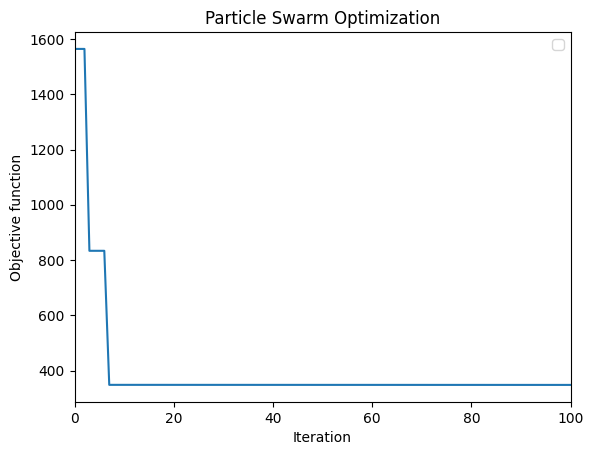

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 48
Melhor Custo: R$ 347,85
Tempo de Convergência para a segunda etapa: 1.493340253829956 segundos


In [292]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization')


# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", melhorCusto)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

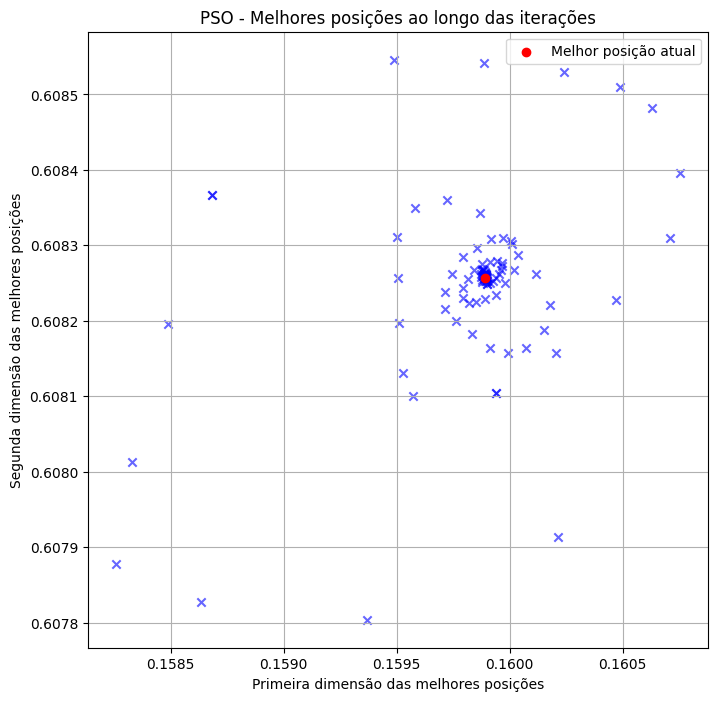

In [293]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [294]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [295]:
# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(melhorCusto)  # Substitua pbest_cost[0] por best_cost

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), melhorCusto, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage,]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [296]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 463,75",149.066011,1.002104,0.571316,0.008755,1.461958,NaN
1,2,"R$ 347,85",149.066011,1.002104,0.571316,0.007282,1.493340,NaN


In [297]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Index                        2 non-null      int64  
 1   Melhor_Custo                 2 non-null      object 
 2   Lambda                       2 non-null      float64
 3   Beta                         2 non-null      float64
 4   Theta                        2 non-null      float64
 5   Convergencia_Primeira_Etapa  2 non-null      float64
 6   Convergencia_Segunda_Etapa   2 non-null      float64
 7   Ciclos_MP                    0 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 256.0+ bytes


In [298]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.0
mean,1.500000,149.066011,1.002104,0.571316,0.008019,1.477649,NaN
std,0.707107,0.000000,0.000000,0.000000,0.001041,0.022191,NaN
min,1.000000,149.066011,1.002104,0.571316,0.007282,1.461958,NaN
25%,1.250000,149.066011,1.002104,0.571316,0.007651,1.469803,NaN
50%,1.500000,149.066011,1.002104,0.571316,0.008019,1.477649,NaN
75%,1.750000,149.066011,1.002104,0.571316,0.008387,1.485495,NaN
max,2.000000,149.066011,1.002104,0.571316,0.008755,1.493340,NaN


In [299]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

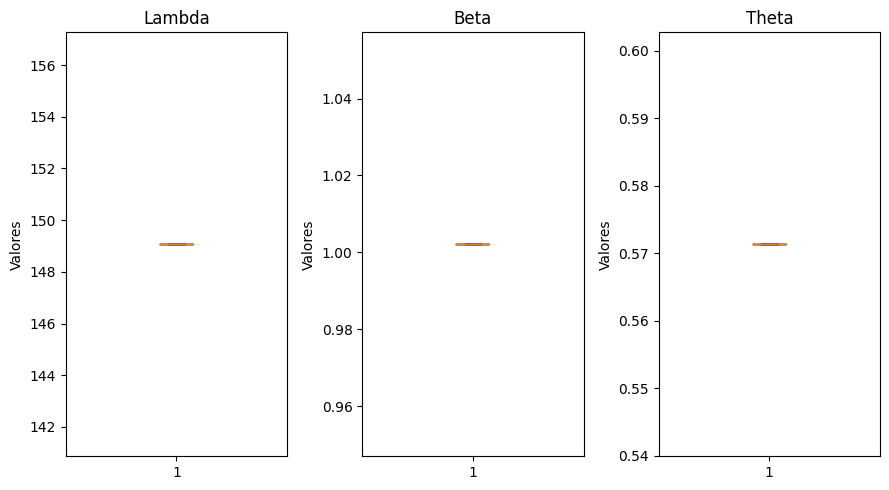

In [300]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [301]:
# # Cria uma grafico para os parameros da segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(param_segunda_etapa):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

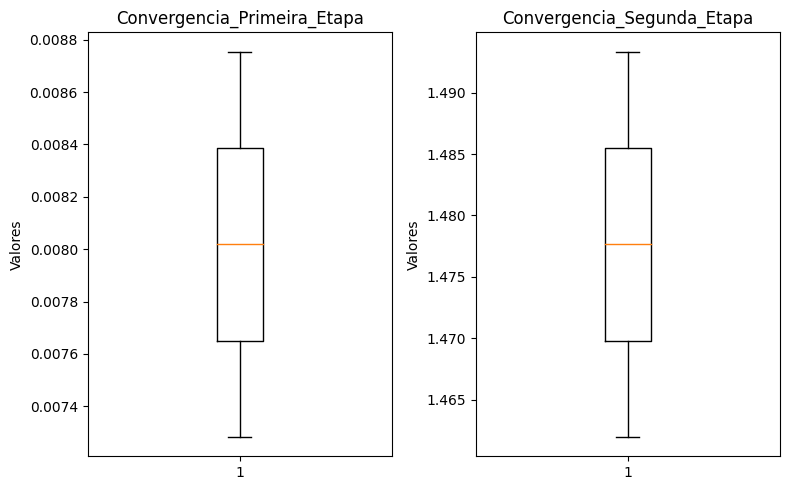

In [302]:
# Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(convergencia):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [303]:
# Arrays de tempos e severidade
Tempos = [
[[72, 137, 158, 209, 239, 276, 308, 340, 377, 466]],
[[9, 79, 155, 186, 234, 360, 531, 543]],
[[131, 208, 352, 403, 434, 514]],
[[78, 117, 177, 252, 274, 403, 478, 582]],
[[95, 138, 200, 282, 566]],
[[81, 105, 203, 233, 439, 464, 488, 623]],
[[98, 202, 216, 245, 317, 392]],
[[95, 163, 321, 359, 425, 460, 509]],
[[18, 37, 443, 617]],
[[60, 105, 122, 198, 242, 305, 342, 404, 432, 471]],
]

severidade = [
  [[0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5]],
  [[0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5]],
  [[0.5, 0.5, 0.75, 0.25, 0.75, 0.5]],
  [[0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75]],
  [[0.25, 0.5, 0.75, 0.5, 0.75]],
  [[0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25]],
  [[0.75, 0.25, 0.75, 0.25, 0.5, 0.25]],
  [[0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25]],
  [[0.75, 0.5, 0.75, 0.5]],
  [[0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25]],
]

# # Verifica se ambos os arrays têm o mesmo número de linhas
# if len(Tempos) == len(severidade):
#     with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
#         file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
#         for i in range(len(Tempos)):
#             row = Tempos[i] + severidade[i]
#             row_str = [str(value) for value in row]
#             file.write(f"{i};{';'.join(row_str)}\n")
# else:
#     print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [304]:
# # Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
# dados.head(10)

In [305]:
# dados.info()

In [306]:
# dados.describe()